# Grover's Algorithm
<hr></hr>

[Grover's algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm), introduced by [Lov Grover](https://en.wikipedia.org/wiki/Lov_Grover) in 1996, marked the second major discovery of a quantum algorithm with a provable advantage, appearing only a few years after Shor’s factoring algorithm. However, unlike Shor’s exponential speedup, Grover’s algorithm provides only a polynomial advantage (specifically, **quadratic**) over the best known classical approaches [[Grover96](https://dl.acm.org/doi/pdf/10.1145/237814.237866)]. In other words, for certain problems that require $N$ steps classically, Grover’s algorithm can find a solution with high probability in roughly $\sqrt{N}$ steps.

Grover's algorithm is also known as the quantum search algorithm, as it addresses the problem of finding which inputs to an arbitrary function evaluate to a specified output value. More precisely, the class of problems it solves can be formulated as instances of an unstructured search, where given a Boolean function $f: \{0, 1\}^n \longmapsto \{0, 1\}$, the goal is to find all inputs $x \in  \{0, 1\}^n$ that evaluate to $f(x) = 1.$

A popular example to describe Grover's algorithm is the task of searching through a phone book to find the person associated with a specific phone number. This is a challenging task since names are listed alphabetically but phone numbers themselves are unordered. So, if there are a total of $N = 2^n$ entries, a classical search may require checking each entry one by one until the number we're looking for is found. In the worst case, this requires going over each of the $N$ entries. And on average, finding entries in an unsorted list takes $N/2$ tries. In contrast, Grover's algorithm can solve this problem by querying the list only $\sqrt{N}$ times. However, as with the other quantum algorithms we've discussed so far, Grover’s algorithm requires that the problem be encoded into a unitary oracle $U_f.$ For a purely classical search task (such as scanning a phone book), constructing the function $f(x)$ needed to build $U_f$ would itself require examining the entire list of numbers. Therefore, Grover's algorithm offers no advantage in this particular example. It is then crucial to recognize that, even though this example is helpful from a pedagogical standpoint, Grover’s algorithm is of practical use **only** when the function $f(x)$ can be implemented and encoded into $U_f$ in an efficient manner. An important task where this condition holds is in the [circuit satisfiability problem](https://en.wikipedia.org/wiki/Circuit_satisfiability_problem), which we will discuss later.

As a matter of convenience, we will start by describing the problem of unstructured search by assuming that the unitary $U_f$ is simply given to us. The details on how to construct $U_f$ for potential applications will be covered in section 3.

## 1. Classical Approach

A good starting point is to consider a function $f(x)$ for which only one (unknown) value of $x$ evaluates to $1.$ It is common to refer to this value as a **marked element**. Below is an example of a function for which the marked element is $m = 101:$

$$
\begin{split}
\begin{aligned}
f(000) &= 0
\\
f(001) &= 0
\\
f(010) &= 0
\\
f(011) &= 0
\\
f(100) &= 0
\\
f(101) &= 1
\\
f(110) &= 0
\\
f(111) &= 0
\end{aligned}
\end{split}
$$

Let's use python to create a function $f(x),$ which evaluates to $1$ for a random marked element $m.$

In [1]:
import numpy as np

In [2]:
def fx_single_m(n):
    N = 2**n
    fx_lst = [0]*N
    
    m_int = np.random.randint(N)
    fx_lst[m_int] = 1
    
    return fx_lst, m_int

In [3]:
n = 3 # number of bits

fx_lst, m_int = fx_single_m(n)
m = np.binary_repr(m_int,n)

print(f'Outcomes for m = {m}\n')
print('x',' '*(n), 'f(x)')

for x_int, fx_int in enumerate(fx_lst):
    x = np.binary_repr(x_int,n)
    fx = np.binary_repr(fx_int,1)
    
    print(x, ' ', fx)

Outcomes for m = 110

x     f(x)
000   0
001   0
010   0
011   0
100   0
101   0
110   1
111   0


As mentioned above, the only way of finding a marked element classically is by evaluating $f(x)$ for each input $x$ until we get an output equal $1$. The probability of succeeded after trying $r$ different inputs is simply given by the ratio between the number of tries and the total number of possible inputs:

$$\mathbb{P}_{\text{success}} = \frac{r}{2^n} .$$

Let us now encode $f(x)$ into a unitary $U_f$ using qiskit:

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import AerSimulator

In [5]:
def black_box_single_m(n):
    N = 2**n
    m_int = np.random.randint(N)
    m = np.binary_repr(m_int,n)
    
    qc_bb = QuantumCircuit(n+1)
    qc_bb.mcx(list(range(1,n+1)),0, ctrl_state=m)
    
    return qc_bb, m

circuit that encodes f(x)=1 for x = 1101


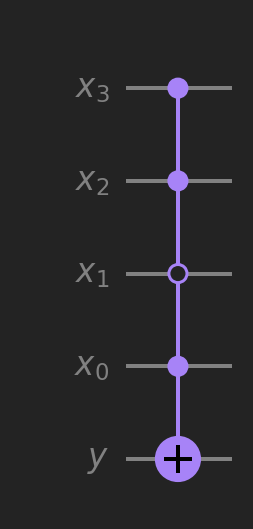

In [6]:
# Draw example circuit for f(x) = 1 when x is the marked element m.
n = 4
bb, m = black_box_single_m(n)

xr = QuantumRegister(n, name='x')
yr = QuantumRegister(1, name='y')

qc = QuantumCircuit(yr,xr)
qc.append(bb,range(n+1))

print(f'circuit that encodes f(x)=1 for x = {m}')
qc.decompose().draw()

As can be seen, the black box circuit is very simple. It consists of an $MCX$ gate for which the controls activate the $X$ gate only when the input $x = m.$ We can then run a simulation for one unknown marked element and see how many accesses to $U_f$ it takes to find it:

In [7]:
n = 5                          # Length (in bits) of marked element
N = 2**n                       # Number of possible values x can take
simulator = AerSimulator()

bb, m = black_box_single_m(n)  # Generate black box and secret string

for x_in in range(N):
    
    qc = QuantumCircuit(n+1,1)
    qc.prepare_state(x_in,range(1,n+1))
    qc.append(bb,range(n+1))
    qc.measure(0,0)

    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 

    fx = job.result().get_memory()[0]

    if fx == '1':
        break
        
print(f'marked element: {m}')
print(f'found after: {x_in} tries out of {N}')

marked element: 00110
found after: 6 tries out of 32


The plot below shows the results of running the simulation above a large number of times for random marked elements of length $n = 5$. As can be seen, the expected probability of success increases linearly as $r/2^n.$ This implies that, it takes $r = 2^n/2 = 2^{n-1}$ tries to find the marked element $m$ with more than $50 \%$ probability, which for $n = 5,$ is $r = 16:$

<img src="images/04_04_01_classical_probs.png" align = "center" width="600"/>

## 2. Quantum Approach

